<a href="https://colab.research.google.com/github/Leegyu66/StyleTransfer/blob/main/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [166]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [167]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [168]:
def load_image(img_path, max_size=128, shape=None):

  image = Image.open(img_path).convert('RGB')

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406),
                           (0.229, 0.224, 0.225))
  ])

  # discard the transparent, alpha channel (that's the :3) and add the batch dimension
  image = in_transform(image)[:3,:,:].unsqueeze(0)

  return image

In [169]:
content = load_image('/content/input/joy.jpg', max_size=512)
style = load_image('/content/input/starry_night.jpg', max_size=512)

In [170]:
def im_convert(tensor):

  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)

  return image

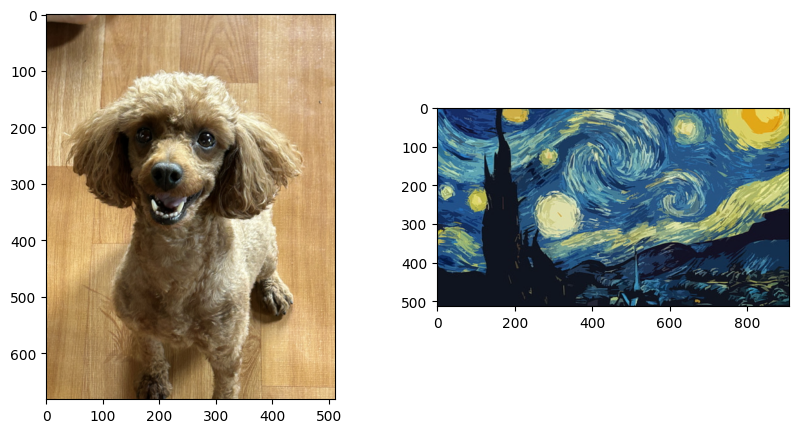

In [171]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [172]:
def get_features(image, model, layers=None):

  if layers is None:
    layers = {'0': 'conv1_1',
              '5': 'conv2_1',
              '10': 'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2',
              '28': 'conv5_1'}
  features = {}
  x = image

  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x

  return features

In [173]:
def gram_matrix(tensor):

  _, d, h, w = tensor.size()

  tensor = tensor.view(d, h*w)

  gram = torch.mm(tensor, tensor.t())

  return gram

In [174]:
content_features = get_features(content.to(device), vgg)
style_features = get_features(style.to(device), vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().to(device)

In [175]:
target.requires_grad = True

In [176]:
style_weights = {'conv1_1': 1,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1
style_weight = 1e3

Total loss:  83891.1015625


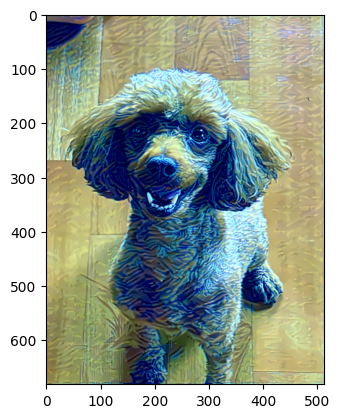

Total loss:  19621.962890625


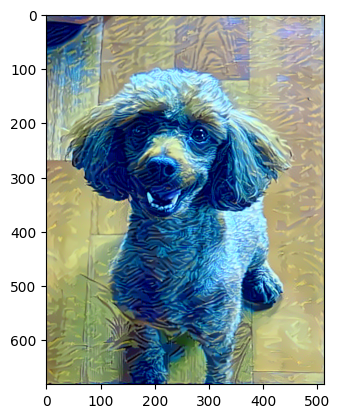

Total loss:  14557.5400390625


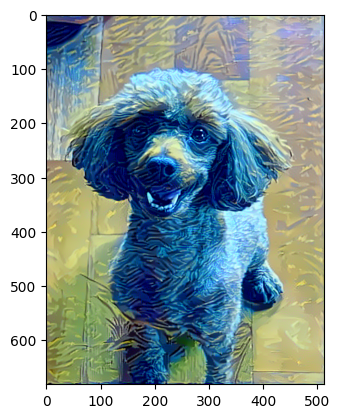

Total loss:  11379.5869140625


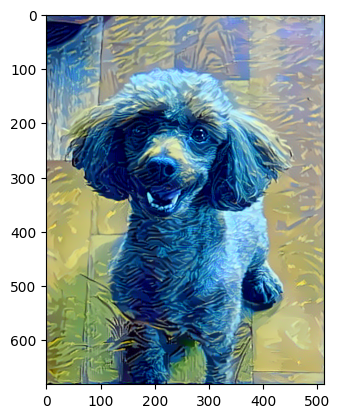

Total loss:  9010.6533203125


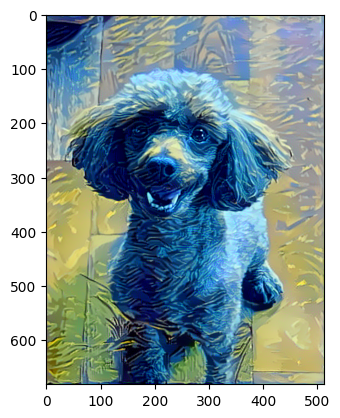

Total loss:  7153.26123046875


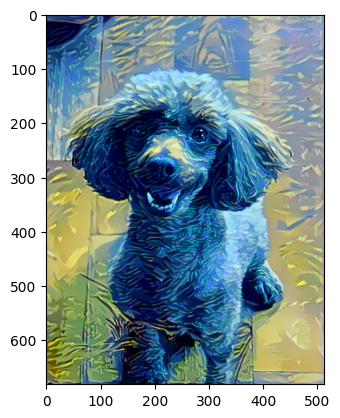

Total loss:  5667.673828125


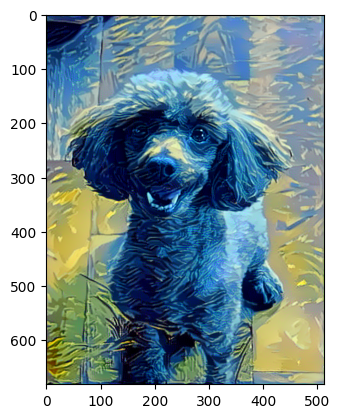

Total loss:  4456.0693359375


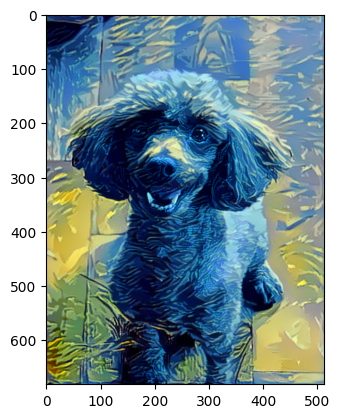

Total loss:  3484.16943359375


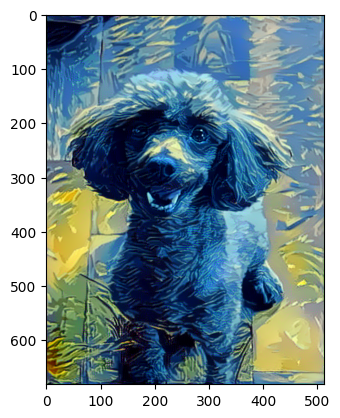

Total loss:  2717.168701171875


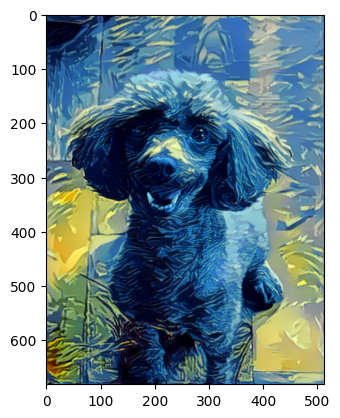

Total loss:  2127.835205078125


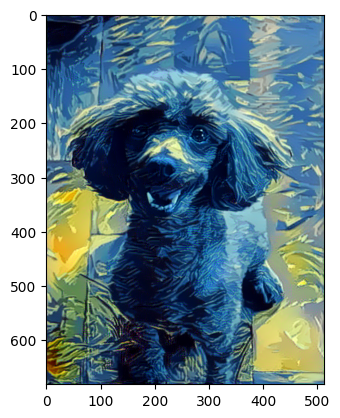

Total loss:  1685.76220703125


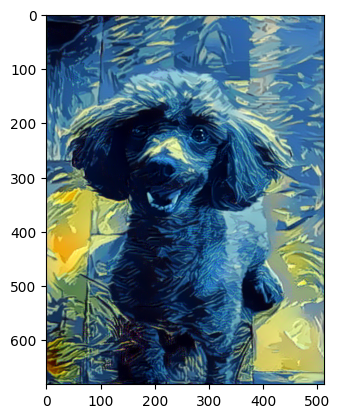

Total loss:  1383.9501953125


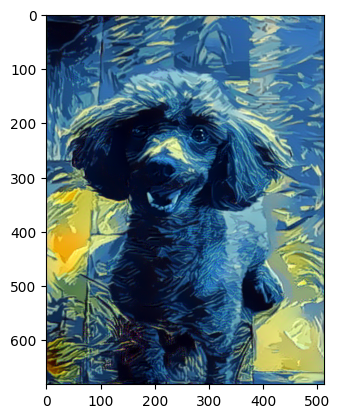

Total loss:  1184.0712890625


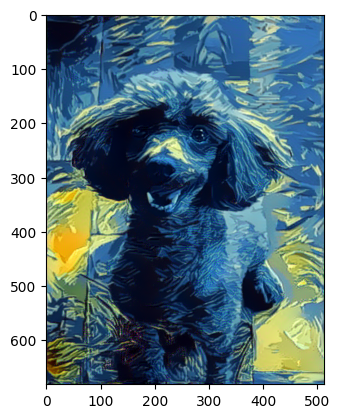

Total loss:  1049.80908203125


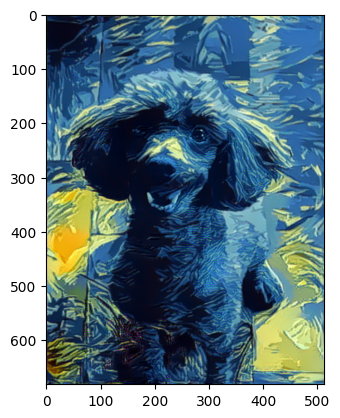

Total loss:  952.249755859375


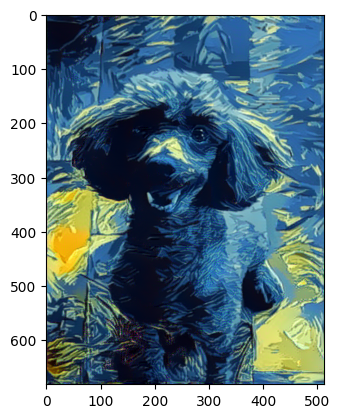

Total loss:  882.9921264648438


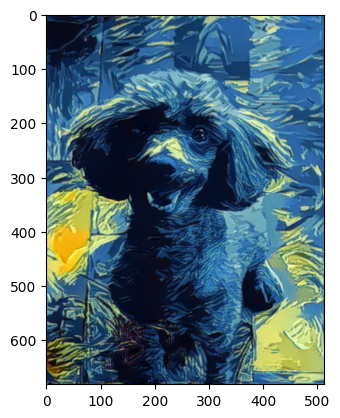

Total loss:  833.4799194335938


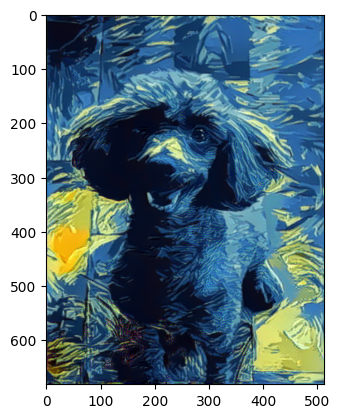

Total loss:  797.1702880859375


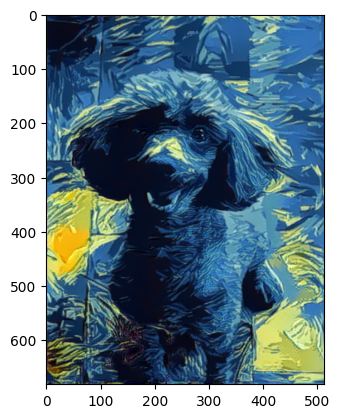

Total loss:  767.7254638671875


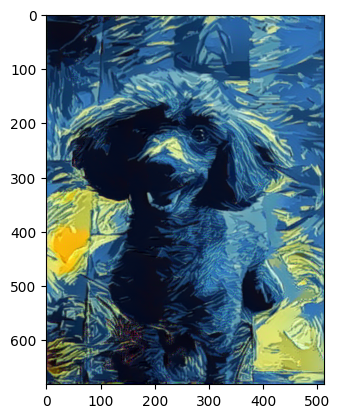

In [177]:
show_every = 500

optimizer = optim.Adam([target], lr=0.003)
steps = 10001

for ii in range(1, steps+1):

  target_features = get_features(target, vgg)

  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

  style_loss = 0

  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    style_loss += layer_style_loss / (d * h * w)

  total_loss = content_weight * content_loss + style_weight * style_loss

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    plt.imshow(im_convert(target))
    plt.show()

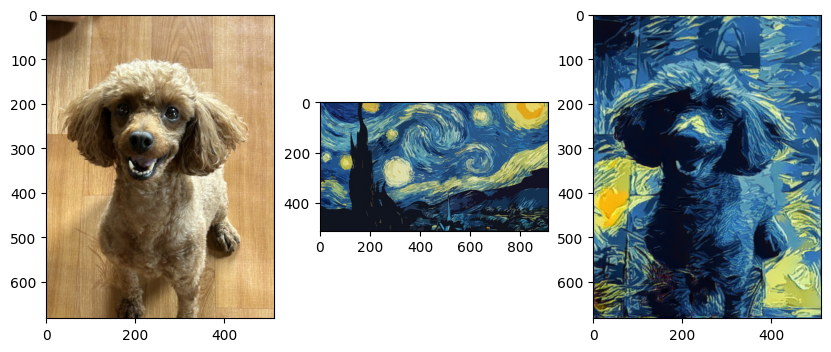

In [178]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(target))